# Titanic Survival Forecasting
#### Tua Wongsangaroonsri and Marika Karibova

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline 

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [2]:
test = pd.read_csv("test.csv", index_col = 'PassengerId')
train = pd.read_csv("train.csv", index_col = 'PassengerId')

In [3]:
test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [6]:
train['Pclass'] = train.Pclass.astype('category')
train['Embarked'] = train.Embarked.astype('category')
train['Sex'] = train.Sex.astype('category')

train = train.drop('Ticket', axis=1)
test = test.drop('Ticket', axis=1)


## Visualizing Relationship

In [7]:
train.loc[:, (train.columns != 'Name')].groupby(['Pclass','Sex']).agg(['count','mean'])

Survived             Age            SibSp           Parch  \
                 count      mean count       mean count      mean count   
Pclass Sex                                                                
1      female       94  0.968085    85  34.611765    94  0.553191    94   
       male        122  0.368852   101  41.281386   122  0.311475   122   
2      female       76  0.921053    74  28.722973    76  0.486842    76   
       male        108  0.157407    99  30.740707   108  0.342593   108   
3      female      144  0.500000   102  21.750000   144  0.895833   144   
       male        347  0.135447   253  26.507589   347  0.498559   347   

                         Fare              
                   mean count        mean  
Pclass Sex                                 
1      female  0.457447    94  106.125798  
       male    0.278689   122   67.226127  
2      female  0.605263    76   21.970121  
       male    0.222222   108   19.741782  
3      female  0.798611   144   16.118810  
       male    0.224784   347   12.661633

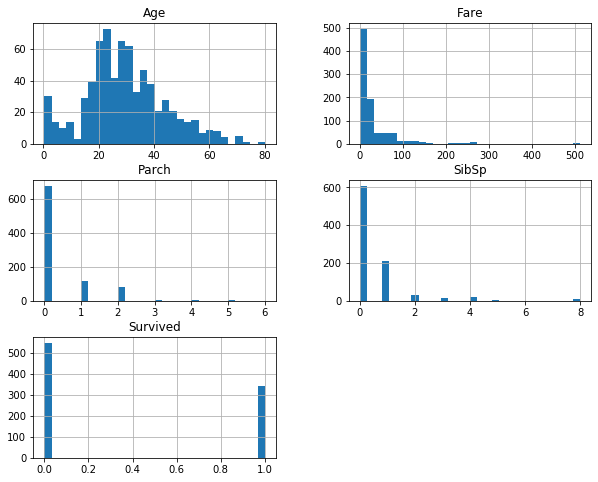

In [8]:
train.hist(bins=30, figsize = (10,8))
plt.show()

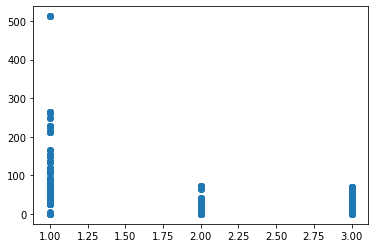

In [9]:
plt.scatter(x=train.Pclass,y=train.Fare)

In [10]:
corr_matrix = train.loc[:, train.columns != 'PassengerId'].corr()
corr_matrix

,Survived,Age,SibSp,Parch,Fare
Survived,1.000000,-0.077221,-0.035322,0.081629,0.257307
Age,-0.077221,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.035322,-0.308247,1.000000,0.414838,0.159651
Parch,0.081629,-0.189119,0.414838,1.000000,0.216225
Fare,0.257307,0.096067,0.159651,0.216225,1.000000


Visualizing the realization between the numerical features shows low correlation between all relevant features and survival rate.  Will have to test whether removing these features would affect the forecast quality in the final result.

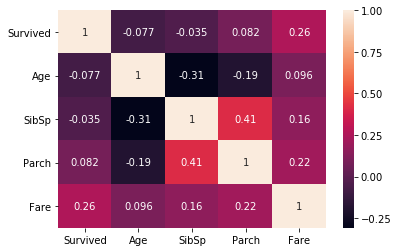

In [11]:
sns.heatmap(corr_matrix, annot=True)
plt.show()

There is a large difference in survival probability between male and female of comparable passenger class.  Female in 3rd class cabin have significantly lower survival probability compared to their peers in 1st and 2nd class.  Conversely, males in 1st class has a significantly higher survival probability compared to their peers

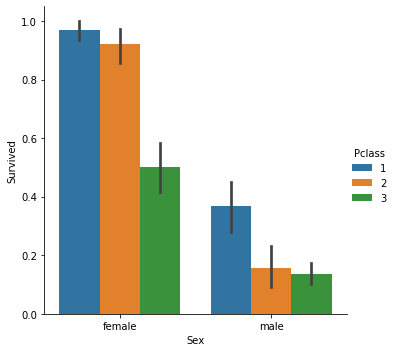

In [12]:
sns.catplot(x="Sex", y="Survived", hue = 'Pclass', kind='bar', data=train)

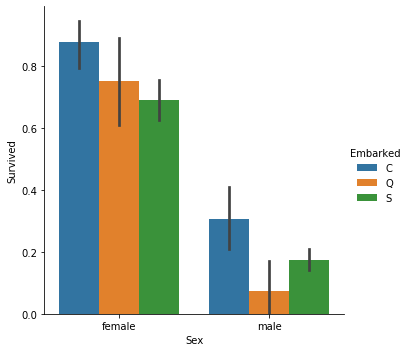

In [13]:
sns.catplot(x="Sex", y="Survived", hue = 'Embarked', kind='bar', data=train)

## Feature Extraction 

#### Salutations
Instead of gender, we are using salutations (Mr, Miss, Mrs) which also captures more information regarding marital status of the sample.   However, since Mr is used for both married and un-married male, this information is only available for female in the sample.  Other rarer salutations (Dr, Rev) are converted to either Mr or Mrs, depending on their gender.   (While there are uncertainty regarding whether to use Miss or Ms, we defaulted to Mrs since these are typically women of higher status).   Also, there are only a total of 7 women with rare salutation, which shouldn't add too much noise in the data.

In [14]:
train['salute'] = [i.partition(',')[2].split()[0] for i in np.array(train.Name)]

In [15]:
train['salute'].value_counts()

Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Major.         2
Mlle.          2
Col.           2
Jonkheer.      1
the            1
Sir.           1
Mme.           1
Ms.            1
Don.           1
Capt.          1
Lady.          1
Name: salute, dtype: int64

In [16]:
raresalut = ['Dr.','Mme.','Rev.','Major.','Col.','Mlle.','Sir.','Ms.','Mme.','the','Lady.','Jonkheer.','Don.','Capt.','Dona.']
train.loc[train['salute'].isin(raresalut), 'Sex'].value_counts()

male      20
female     7
Name: Sex, dtype: int64

In [17]:
train.loc[(train['salute'].isin(raresalut)) & (train['Sex']=='male'), 'salute'] = 'Mr.'
train.loc[(train['salute'].isin(raresalut)) & (train['Sex']=='female'), 'salute'] = 'Mrs.'

In [18]:
train['salute'].value_counts()

Mr.        537
Miss.      182
Mrs.       132
Master.     40
Name: salute, dtype: int64

#### Extracting Cabin Location 
For additional information, we are considering the to use cabin number as an additional indicator (Extracting cabin as first letter from the cabin column). For instance, a guest in the lower cabin would be located further away from life-boat on the deck, which could lower their survival rate.  While there are concerns that the guest might not be in their cabin, at the collision time slightly before midnight, it would be reasonable to suspect that many guests had already retired to their cabin.  
However, there is concern due to large number of missing data, which could be systematic.  This is supported by different survival percentage of the group with and without cabin number.  We model this by creating another dummy to represent the group without cabin number. Due to low number of each cabin in the data-set, we grouped them into upper cabin (A - C) and lower cabin (D - T) according to the cabin map. 

Information regarding time of sinking from the link below
https://www.history.com/this-day-in-history/titanic-sinks0

Location regarding for each cabin comes from below.  
https://en.wikipedia.org/wiki/First_class_facilities_of_the_RMS_Titanic#/media/File:Titanic_cutaway_diagram.png

In [19]:
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [20]:
train.loc[(train['Cabin'].isna())]['Survived'].value_counts()

0    481
1    206
Name: Survived, dtype: int64

In [21]:
train.loc[(train['Cabin'].isna())]['Survived'].value_counts()/len(train.loc[(train['Cabin'].isna())]['Survived'])

0    0.700146
1    0.299854
Name: Survived, dtype: float64

In [22]:
train.loc[(train['Cabin'].notna())]['Survived'].value_counts()

1    136
0     68
Name: Survived, dtype: int64

In [23]:
train.loc[(train['Cabin'].notna())]['Survived'].value_counts()/len(train.loc[(train['Cabin'].notna())]['Survived'])

1    0.666667
0    0.333333
Name: Survived, dtype: float64

In [24]:
train.loc[(train['Cabin'].isnull()), 'Cabin'] = 'X'
train['cabin_type'] = [list(i)[0] for i in train['Cabin']]
train['cabin_type'].value_counts()

X    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: cabin_type, dtype: int64

In [25]:
upperdeck = ['A','B','C']
lowerdeck = ['D','E','F','G','T']

train.loc[(train['cabin_type'].isin(upperdeck)), 'cabin_type'] = 'Upper'
train.loc[(train['cabin_type'].isin(lowerdeck)), 'cabin_type'] = 'Lower'

train['cabin_type'].value_counts()

X        687
Upper    121
Lower     83
Name: cabin_type, dtype: int64

## Feature Preprocessing

In [26]:
X = train.copy()
X  = X.drop(columns = ['Survived','Cabin','Name','Sex'])
X = pd.get_dummies(X)

y = train.copy()
y = train[['Survived']]

X_train, X_test, y_train, y_test = train_test_split(X ,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=123)

X_train_orig = X_train.copy()
X_test_orig = X_test.copy()

In [27]:
numeric = ['Age','SibSp','Parch','Fare']

numpipe = Pipeline([
        ('nummiss', SimpleImputer(missing_values=np.nan, strategy="mean")),
        ('std_scaler', StandardScaler()
        )])

transform = ColumnTransformer(transformers=[
        ('num', numpipe, numeric)],
        remainder='passthrough')


In [28]:
trained_transform = transform.fit(X_train)

X_train  = trained_transform.transform(X_train)
X_train = pd.DataFrame(X_train, columns = X.columns)

X_test  = trained_transform.transform(X_test)
X_test = pd.DataFrame(X_test, columns = X.columns)
X_test

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,salute_Master.,salute_Miss.,salute_Mr.,salute_Mrs.,cabin_type_Lower,cabin_type_Upper,cabin_type_X
0,-2.264638,0.437413,0.829588,-0.407331,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.000000,-0.460103,-0.474312,-0.482149,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.013124,-0.460103,-0.474312,-0.088890,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,2.447973,-0.460103,-0.474312,0.021303,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,-0.222507,0.437413,-0.474312,-0.343690,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,0.000000,-0.460103,-0.474312,-0.472567,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
175,1.191277,-0.460103,-0.474312,-0.466419,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
176,-2.264638,-0.460103,2.133489,0.088457,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
177,0.000000,-0.460103,-0.474312,-0.482229,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


## Processing Forecasting Data

Similar transformation process is applied to the prediction data as above to extract additional features with cabin and salutations.  Convert categorical into dummies using get_dummies function, and to standardize numerical variables.

In [29]:
predset = test.copy()
predset['Pclass'] = predset.Pclass.astype('category')

# Feature Extraction for Prediction data (Salutation)
predset['salute'] = [i.partition(',')[2].split()[0] for i in np.array(predset.Name)]
predset.loc[(predset['Cabin'].isnull()), 'Cabin'] = 'X'
predset.loc[(predset['salute'].isin(raresalut)) & (predset['Sex']=='male'), 'salute'] = 'Mr.'
predset.loc[(predset['salute'].isin(raresalut)) & (predset['Sex']=='female'), 'salute'] = 'Mrs.'


# Feature Extraction for Prediction data (Cabin)
predset['cabin_type'] = [list(i)[0] for i in predset['Cabin']]
train.loc[(train['salute'].isin(raresalut)) & (train['Sex']=='male'), 'salute'] = 'Mr.'
train.loc[(train['salute'].isin(raresalut)) & (train['Sex']=='female'), 'salute'] = 'Mrs.'

upperdeck = ['A','B','C']
lowerdeck = ['D','E','F','G','T']

predset.loc[(predset['cabin_type'].isin(upperdeck)), 'cabin_type'] = 'Upper'
predset.loc[(predset['cabin_type'].isin(lowerdeck)), 'cabin_type'] = 'Lower'

#Feature Preprocessing for Prediction Data
predset  = predset.drop(columns = ['Cabin','Name','Sex'])
predset = pd.get_dummies(predset)
predset.head()

predset = trained_transform.transform(predset)
predset = pd.DataFrame(predset, columns = X.columns)
pred_id = test.reset_index()['PassengerId']

predset.head()

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,salute_Master.,salute_Miss.,salute_Mr.,salute_Mrs.,cabin_type_Lower,cabin_type_Upper,cabin_type_X
0,0.366570,-0.460103,-0.474312,-0.470650,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1.348364,0.437413,-0.474312,-0.486541,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,2.526517,-0.460103,-0.474312,-0.435038,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,-0.222507,-0.460103,-0.474312,-0.454681,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,-0.615224,0.437413,0.829588,-0.385212,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


## Model Selection

For model selection we consider three classes of model using GridSearchCV algorithm (LR, RF, and KNN).  LR is shown to give the lowest cross validation error of the three classes.

In [30]:
pipe = Pipeline([('classifier', LogisticRegression(solver='lbfgs'))])
search_space = [{'classifier': [LogisticRegression(solver='lbfgs')],
                 'classifier__C': [0.01, 0.1, 1.0]},
                {'classifier': [RandomForestClassifier(random_state = 123)],
                 'classifier__n_estimators': [10, 50, 100,500],
                 'classifier__max_depth': [None, 10, 15, 20, 25]},
                {'classifier': [KNeighborsClassifier()],
                 'classifier__n_neighbors':[1,10,20]}]
                
clf = GridSearchCV(pipe, search_space, cv=5, verbose=10, n_jobs=-1)
best_model=clf.fit(X_train,y_train)

Fitting 5 folds for each of 26 candidates, totalling 130 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:   16.1s finished


In [31]:
best_model.best_estimator_.get_params()['classifier']

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [32]:
print('Best Model Training Error: {} '.format(round(1-best_model.score(X_train,y_train),5)))
print('Best Model Cross Validated Error: {} '.format(round(1-best_model.best_score_,5)))
print('Best Model Test Error:{}'.format(round(1-best_model.score(X_test,y_test),5)))

Best Model Training Error: 0.17556 
Best Model Cross Validated Error: 0.17836 
Best Model Test Error:0.13966


In [33]:
best_model.cv_results_['mean_test_score']

array([0.75428937, 0.82163892, 0.82025017, 0.78646705, 0.79072195,
       0.78930365, 0.7907121 , 0.80893332, 0.80897272, 0.81318822,
       0.81459667, 0.78930365, 0.80192061, 0.79912341, 0.80334876,
       0.7780656 , 0.78652615, 0.79072195, 0.79212056, 0.78646705,
       0.79212056, 0.78930365, 0.7893135 , 0.75981483, 0.79918251,
       0.81605437])

In [34]:
coef = best_model.best_estimator_[0].coef_.reshape([best_model.best_estimator_[0].coef_.shape[1],]) 
coef.shape
coef

array([-0.26894243, -0.3655621 , -0.08911225,  0.19773561,  0.45369874,
        0.13742267, -0.59106915,  0.1167257 ,  0.05887389, -0.20155233,
        0.26986457,  0.51220479, -1.61750591,  0.83548882,  0.36120302,
        0.05304242, -0.41419318])

## Logistic Regression Tuning

This section is to ceck for potential interactions of features in logistic regression.   Possible interactions being tested in this section has the following format to capture the possible differences in which number of parent-children and siblings on board affect survivability across different gender and age.  (Male sibling may give space on lifeboat to female sibling etc.)
1. Age x Parent-Child 
2. Salutations x Parent-Child 
3. Age x Sibling
4. Salutations x Siblings

In [35]:
pd.DataFrame({'coefficients':coef},index = X_train.columns).sort_values(by='coefficients', ascending = False)

,coefficients
salute_Mrs.,0.835489
salute_Miss.,0.512205
Pclass_1,0.453699
cabin_type_Lower,0.361203
salute_Master.,0.269865
Fare,0.197736
Pclass_2,0.137423
Embarked_C,0.116726
Embarked_Q,0.058874
cabin_type_Upper,0.053042


In [36]:
# Adding possible interaction terms

def add_feature(df): 
    df2 = df.copy()
    
    #Parch and Age (Parch contains both children and parent. High parch at high age could more likely means children, which reduces the parents' chance of survival by prioritizing children's
    df2['Parch_age'] = df['Parch'] * df['Age']
    df2['Parch_Mrs'] = df['Parch'] * df['salute_Mrs.']
    df2['Parch_Miss'] = df['Parch'] * df['salute_Miss.']
    df2['Parch_Master'] = df['Parch'] * df['salute_Master.']
    df2['Parch_Mr'] = df['Parch'] * df['salute_Mr.']

    #SibSp and Age (Sibling may apply for people who are older.)
    #Male sibling maybe more expected to protect female siblings, while female siblings are more likely to be given a spot on the lifeboat from their male siblings
    df2['Sib_age'] = df['SibSp'] * df['Age']
    df2['Sib_Mrs'] = df['SibSp'] * df['salute_Mrs.']
    df2['Sib_Miss'] = df['SibSp'] * df['salute_Miss.']
    df2['Sib_Master'] = df['SibSp'] * df['salute_Master.']
    df2['Sib_Mr'] = df['SibSp'] * df['salute_Mr.']
    
    return df2

In [37]:
X_train2 = add_feature(X_train_orig)
X_test2 = add_feature(X_test_orig)
train2_name = X_train2.columns


In [38]:
X_test2

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,...,Parch_age,Parch_Mrs,Parch_Miss,Parch_Master,Parch_Mr,Sib_age,Sib_Mrs,Sib_Miss,Sib_Master,Sib_Mr
PassengerId,,,,,,,,,,,,,,,,,,,,,
173,1.0,1,1,11.1333,0,0,1,0,0,1,...,1.0,0,1,0,0,1.0,0,1,0,0
525,NaN,0,0,7.2292,0,0,1,1,0,0,...,NaN,0,0,0,0,NaN,0,0,0,0
453,30.0,0,0,27.7500,1,0,0,1,0,0,...,0.0,0,0,0,0,0.0,0,0,0,0
171,61.0,0,0,33.5000,1,0,0,0,0,1,...,0.0,0,0,0,0,0.0,0,0,0,0
621,27.0,1,0,14.4542,0,0,1,1,0,0,...,0.0,0,0,0,0,27.0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389,NaN,0,0,7.7292,0,0,1,0,1,0,...,NaN,0,0,0,0,NaN,0,0,0,0
339,45.0,0,0,8.0500,0,0,1,0,0,1,...,0.0,0,0,0,0,0.0,0,0,0,0
828,1.0,0,2,37.0042,0,1,0,1,0,0,...,2.0,0,0,2,0,0.0,0,0,0,0


In [39]:
def stardardizing(df):
    numeric = ['Age','SibSp','Parch','Fare','Parch_age','Parch_Mrs','Parch_Miss','Parch_Master','Parch_Mr','Sib_age','Sib_Mrs','Sib_Miss','Sib_Master','Sib_Mr']
    cat = [i for i in train2_name if i not in numeric]

    numpipe = Pipeline([
            ('nummiss', SimpleImputer(missing_values=np.nan, strategy="mean")),
            ('std_scaler', StandardScaler()
            )])

    transform = ColumnTransformer(transformers=[
            ('num', numpipe, numeric)],
            remainder='passthrough')
    
    trained_transform2 = transform.fit(df)

    df2 = trained_transform2.transform(df)
    df2 = pd.DataFrame(df2, columns = (numeric + cat))
    
    return df2

In [40]:
X_train2 = stardardizing(X_train2)
X_test2 = stardardizing(X_test2)

In [41]:
X_test2

,Age,SibSp,Parch,Fare,Parch_age,Parch_Mrs,Parch_Miss,Parch_Master,Parch_Mr,Sib_age,...,Embarked_C,Embarked_Q,Embarked_S,salute_Master.,salute_Miss.,salute_Mr.,salute_Mrs.,cabin_type_Lower,cabin_type_Upper,cabin_type_X
0,-2.016582e+00,0.414308,0.582097,-0.534701,-0.352302,-0.211753,1.975194,-0.232006,-0.202467,-5.897470e-01,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,-2.540899e-16,-0.536476,-0.481121,-0.637342,0.000000,-0.211753,-0.276779,-0.232006,-0.202467,-1.020172e-16,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,5.749728e-02,-0.536476,-0.481121,-0.097841,-0.382324,-0.211753,-0.276779,-0.232006,-0.202467,-6.471776e-01,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,2.274616e+00,-0.536476,-0.481121,0.053329,-0.382324,-0.211753,-0.276779,-0.232006,-0.202467,-6.471776e-01,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,-1.570626e-01,0.414308,-0.481121,-0.447393,-0.382324,-0.211753,-0.276779,-0.232006,-0.202467,9.034482e-01,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,-2.540899e-16,-0.536476,-0.481121,-0.624196,0.000000,-0.211753,-0.276779,-0.232006,-0.202467,-1.020172e-16,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
175,1.130297e+00,-0.536476,-0.481121,-0.615763,-0.382324,-0.211753,-0.276779,-0.232006,-0.202467,-6.471776e-01,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
176,-2.016582e+00,-0.536476,1.645316,0.145456,-0.322280,-0.211753,-0.276779,4.959126,-0.202467,-6.471776e-01,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
177,-2.540899e-16,-0.536476,-0.481121,-0.637452,0.000000,-0.211753,-0.276779,-0.232006,-0.202467,-1.020172e-16,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [42]:
finalmodel = LogisticRegression(solver='lbfgs', C=0.1)
finalres = finalmodel.fit(X_train,y_train)

print('Standard Model Score (Train):{}'.format(round(finalres.score(X_train,y_train),5)))
print('Standard Model Score (Test):{}'.format(round(finalres.score(X_test,y_test),5)))

Standard Model Score (Train):0.82444
Standard Model Score (Test):0.86034


In [43]:
finalmodel = LogisticRegression(solver='lbfgs', C=0.1)
finalres = finalmodel.fit(X_train2,y_train)

print('Interaction Model Score (Train):{}'.format(round(finalres.score(X_train2,y_train),5)))
print('Interaction Model Score (Test):{}'.format(round(finalres.score(X_test2,y_test),5)))

Interaction Model Score (Train):0.83567
Interaction Model Score (Test):0.85475


**Result**:  Adding interaction incrases the training score but lower test score, which indicate overfitting.  Better to use simpler model which has both higher score and more simple

In [44]:
coef = finalres.coef_.reshape([finalres.coef_.shape[1],]) 
pd.DataFrame({'coefficients':coef},index = X_train2.columns).sort_values(by='coefficients', ascending = False)

,coefficients
salute_Miss.,0.629283
salute_Mrs.,0.553006
Pclass_1,0.429867
cabin_type_Lower,0.371760
Parch_Master,0.311387
salute_Master.,0.245798
Fare,0.244393
Sib_Mrs,0.238728
Pclass_2,0.137264
Embarked_C,0.110307


#### Generating Prediction

In [45]:
predproba = best_model.best_estimator_.predict_proba(predset)
predresult = [1 if i[0]<=0.5 else 0 for i in predproba]
predresult = list(zip(pred_id,predresult))

preddf = pd.DataFrame(predresult, columns = ['PassengerId','Survived'])
preddf = preddf.set_index('PassengerId')
preddf.to_csv('SurvivalProb_Logistic.csv')

# XGBoost

Lastly, we consider XGBoost as the final algorithm to improve the model result.

Information regarding XGBoost from 
https://towardsdatascience.com/a-beginners-guide-to-xgboost-87f5d4c30ed7

In [46]:
from sklearn import datasets
import xgboost as xgb

In [47]:
X_train.head()

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,salute_Master.,salute_Miss.,salute_Mr.,salute_Mrs.,cabin_type_Lower,cabin_type_Upper,cabin_type_X
0,-1.086485,-0.460103,0.829588,0.490420,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.091668,-0.460103,-0.474312,-0.472168,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,1.230549,-0.460103,-0.474312,-0.482229,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,-0.693768,-0.460103,-0.474312,-0.472488,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,-0.536681,-0.460103,0.829588,0.593505,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [48]:
D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)

In [49]:
# Change num_class to 2, since we only have 2 classes (Survived, Not Survived) in the data-set
param = {
    'eta': 0.3, 
    'max_depth': 3,  
    'objective': 'multi:softprob',  
    'num_class': 2} 

steps = 20  # The number of training iterations

### Standard Fitting

In [50]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score

model_xgb = xgb.train(param, D_train, steps)
preds = model_xgb.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(round(precision_score(y_test, best_preds, average='macro'),5)))
print("Recall = {}".format(round(recall_score(y_test, best_preds, average='macro'),5)))
print("Accuracy = {}".format(round(accuracy_score(y_test, best_preds),5)))

Precision = 0.85146
Recall = 0.84406
Accuracy = 0.86034


In [51]:
# Default 
# eta = 0.3
# maxdepth = 6
# min_child_weight = 1
# gamma = 0
# colsample_bytree = 1 

clf_xgb = xgb.XGBClassifier()
xgbfit = clf_xgb.fit(X_train,y_train)

In [52]:
xgbfit.score(X_test,y_test)

0.8770949720670391

### GridSearch

In [53]:
#Let's take a look at the grid
# This code chunk is not running (takes a lot of time to activate)
clf_xgb = xgb.XGBClassifier()
parameters = {
     "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     "max_depth"        : [ 4, 5, 6, 8, 10],
     "min_child_weight" : [ 1, 3, 5, 7 ],
     "gamma"            : [ 0.2 , 0.3, 0.4 ],
     "colsample_bytree" : [ 0.4, 0.5 , 0.7, 1, 1.2 ]
     }

grid_xgb = GridSearchCV(clf_xgb,
                    parameters, n_jobs=-1,
                    scoring="neg_log_loss",
                    cv=3)

grid_xgb.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estim...
                                     subsample=None, tree_method=None,
                                     validate_parameters=False,
                                     verbosity=None),
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bytree': [0.4, 0

In [54]:
grid_xgb.best_estimator_.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eta=0.05, gamma=0.3,
              gpu_id=-1, importance_type='gain', interaction_constraints=None,
              learning_rate=0.0500000007, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)>

In [55]:
print('XGBoost Best Train Score:{}'.format(round(grid_xgb.best_estimator_.score(X_train, y_train),5)))
print('XGBoost Best CV Score:{}'.format(round(cross_val_score(grid_xgb.best_estimator_, X_train, y_train, cv=5).mean(),5)))
print('XGBoost Best Test Score:{}'.format(round(grid_xgb.best_estimator_.score(X_test, y_test),5)))

XGBoost Best Train Score:0.88343
XGBoost Best CV Score:0.82305
XGBoost Best Test Score:0.86592


In [56]:
xg_default = clf_xgb.fit(X_train, y_train)
print('XGBoost Default Train Score:{}'.format(round(xg_default.score(X_train, y_train),5)))
print('XGBoost Default CV Score:{}'.format(round(cross_val_score(xg_default, X_train, y_train, cv=5).mean(),5)))
print('XGBoost Default Test Score:{}'.format(round(xg_default.score(X_test, y_test),5)))

XGBoost Default Train Score:0.9677
XGBoost Default CV Score:0.79351
XGBoost Default Test Score:0.87709


### Predicting Probability

In [57]:
predproba = grid_xgb.best_estimator_.predict_proba(predset)
predresult = [1 if i[0]<=0.5 else 0 for i in predproba]
predresult = list(zip(pred_id,predresult))

preddf = pd.DataFrame(predresult, columns = ['PassengerId','Survived'])
preddf = preddf.set_index('PassengerId')
preddf.to_csv('SurvivalProb_XGBoost.csv')

In [58]:
predproba = xg_default.predict_proba(predset)
predresult = [1 if i[0]<=0.5 else 0 for i in predproba]
predresult = list(zip(pred_id,predresult))

preddf = pd.DataFrame(predresult, columns = ['PassengerId','Survived'])
preddf = preddf.set_index('PassengerId')
preddf.to_csv('SurvivalProb_DefaultXGBoost.csv')


# Features Elimination

To eliminate unnecessary features, we consider the section below to test the effect of iteratively removing features which we considered to have low correlation with survival rate.  These variables are Age, Parch, SibSp, Embarked, and Cabin

After which, we reapply the above algorithms to generate prediction regarding survival probability.

### XGBoost

In [59]:
#Removing Age, SibSp, Parch
X_trim = X_train.drop(columns=['Age','SibSp','Parch'])
X_test_trim = X_test.drop(columns=['Age','SibSp','Parch'])
predset_trim = predset.drop(columns=['Age','SibSp','Parch'])

xg_trim = clf_xgb.fit(X_trim, y_train)
print('XGBoost Trimmed Features Train Score:{}'.format(round(xg_trim.score(X_trim, y_train),5)))
print('XGBoost Trimmed Features CV Score:{}'.format(round(cross_val_score(xg_trim, X_trim, y_train, cv=5).mean(),5)))

predproba = xg_trim.predict_proba(predset_trim)
predresult = [1 if i[0]<=0.5 else 0 for i in predproba]
predresult = list(zip(pred_id,predresult))

preddf = pd.DataFrame(predresult, columns = ['PassengerId','Survived'])
preddf = preddf.set_index('PassengerId')
preddf.to_csv('SurvivalProb_TrimmedXGBoost.csv')

XGBoost Trimmed Features Train Score:0.91433
XGBoost Trimmed Features CV Score:0.81601


In [60]:
#Removing Embarked
X_noembark = X_trim.drop(columns=['Embarked_C','Embarked_Q','Embarked_S'])
X_test_noembark= X_test_trim.drop(columns=['Embarked_C','Embarked_Q','Embarked_S'])
predset_noembark = predset_trim.drop(columns=['Embarked_C','Embarked_Q','Embarked_S'])

xg_noembark = clf_xgb.fit(X_noembark, y_train)
print('XGBoost Trimmed Features Train Score:{}'.format(round(xg_noembark.score(X_noembark, y_train),5)))
print('XGBoost Trimmed Features CV Score:{}'.format(round(cross_val_score(xg_noembark, X_noembark, y_train, cv=5).mean(),5)))

predproba = xg_trim.predict_proba(predset_noembark)
predresult = [1 if i[0]<=0.5 else 0 for i in predproba]
predresult = list(zip(pred_id,predresult))

preddf = pd.DataFrame(predresult, columns = ['PassengerId','Survived'])
preddf = preddf.set_index('PassengerId')
preddf.to_csv('SurvivalProb_NoEmbarkedXGBoost.csv')

XGBoost Trimmed Features Train Score:0.90309
XGBoost Trimmed Features CV Score:0.81744


In [61]:
#Removing Cabin
X_nocabin = X_noembark.drop(columns=['cabin_type_Lower','cabin_type_Upper','cabin_type_X'])
X_test_nocabin= X_test_noembark.drop(columns=['cabin_type_Lower','cabin_type_Upper','cabin_type_X'])
predset_nocabin= predset_noembark.drop(columns=['cabin_type_Lower','cabin_type_Upper','cabin_type_X'])

xg_nocabin= clf_xgb.fit(X_nocabin, y_train)
print('XGBoost Trimmed Features Train Score:{}'.format(round(xg_nocabin.score(X_nocabin, y_train),5)))
print('XGBoost Trimmed Features CV Score:{}'.format(round(cross_val_score(xg_nocabin, X_nocabin, y_train, cv=5).mean(),5)))

predproba = xg_trim.predict_proba(predset_nocabin)
predresult = [1 if i[0]<=0.5 else 0 for i in predproba]
predresult = list(zip(pred_id,predresult))

preddf = pd.DataFrame(predresult, columns = ['PassengerId','Survived'])
preddf = preddf.set_index('PassengerId')
preddf.to_csv('SurvivalProb_NoCabinXGBoost.csv')

XGBoost Trimmed Features Train Score:0.89466
XGBoost Trimmed Features CV Score:0.82448


## Gridsearch with Trimmed Data Set

In [62]:
grid_nocabin = grid_xgb.fit(X_nocabin, y_train)

In [63]:
grid_nocabin.best_estimator_.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.05, gamma=0.4,
              gpu_id=-1, importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=8,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)>

In [64]:
print('XGBoost Best Train Score:{}'.format(round(grid_nocabin.best_estimator_.score(X_nocabin, y_train),5)))
print('XGBoost Trimmed Features CV Score:{}'.format(round(cross_val_score(grid_nocabin.best_estimator_, X_nocabin, y_train, cv=5).mean(),5)))
print('XGBoost Best Test Score:{}'.format(round(grid_nocabin.best_estimator_.score(X_test_nocabin, y_test),5)))

XGBoost Best Train Score:0.86236
XGBoost Trimmed Features CV Score:0.8315
XGBoost Best Test Score:0.87151


In [65]:
predproba = grid_nocabin.best_estimator_.predict_proba(predset_nocabin)
predresult = [1 if i[0]<=0.5 else 0 for i in predproba]
predresult = list(zip(pred_id,predresult))

preddf = pd.DataFrame(predresult, columns = ['PassengerId','Survived'])
preddf = preddf.set_index('PassengerId')
preddf.to_csv('SurvivalProb_BestTrimmedXGBoost.csv')

### Logistic

In [66]:
logistic = LogisticRegression(solver='lbfgs', C=0.1)
logres = logistic.fit(X_trim,y_train)

print('Interaction Model Score (Train):{}'.format(round(logres.score(X_trim,y_train),5)))
print('XGBoost Trimmed Features CV Score:{}'.format(round(cross_val_score(logres, X_trim, y_train, cv=5).mean(),5)))

predproba = logres.predict_proba(predset_trim)
predresult = [1 if i[0]<=0.5 else 0 for i in predproba]
predresult = list(zip(pred_id,predresult))

preddf = pd.DataFrame(predresult, columns = ['PassengerId','Survived'])
preddf = preddf.set_index('PassengerId')
preddf.to_csv('SurvivalProb_TrimmedLogistic.csv')

Interaction Model Score (Train):0.80197
XGBoost Trimmed Features CV Score:0.79354


In [67]:
logistic = LogisticRegression(solver='lbfgs', C=0.1)
logres = logistic.fit(X_nocabin,y_train)

print('Interaction Model Score (Train):{}'.format(round(logres.score(X_nocabin,y_train),5)))
print('XGBoost Trimmed Features CV Score:{}'.format(round(cross_val_score(logres, X_nocabin, y_train, cv=5).mean(),5)))

predproba = logres.predict_proba(predset_nocabin)
predresult = [1 if i[0]<=0.5 else 0 for i in predproba]
predresult = list(zip(pred_id,predresult))

preddf = pd.DataFrame(predresult, columns = ['PassengerId','Survived'])
preddf = preddf.set_index('PassengerId')
preddf.to_csv('SurvivalProb_NoCabinLogistic.csv')

Interaction Model Score (Train):0.79354
XGBoost Trimmed Features CV Score:0.79076
